<a href="https://colab.research.google.com/github/wdoppenberg/mp-operational-envelope/blob/master/OperationalEnvelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Delfi-PQ VLM-LPM In-orbit Demonstrator Operational Envelope Analysis**



This notebook is part of the Individual Assignment for the course AE4S07 Micropropulsion, and will analyse the operational envelope of the Delfi-PQ microthruster demonstrator platform. This demonstrator was designed by L. A. Turmaine as part of a thesis, and was done so in accordance with system level requirements set by Delft University of Technology. 

The report starts with the main problem statement, followed by some background information. After this, the current operational envelope reproducibility study is presented, along with the derived optimisation strategies. Finally the implementation of such strategies is given, as well as the effects this has on the demonstrator platform design.


## Research question

Delft University of technology is currently developing and testing two different types of micro-resistojets: the Vaporizing Liquid Micro-resistojet (VLM) and the Low Pressure Micro-resistojet (LPM). The VLM operates by vaporising slightly pressurised liquid water, whereas the LPM is based on the free molecular acceleration of propellant molecules stored at very low pressure. Both of these platforms require in-flight validation, which is the reason why there have been several studies into designing a demonstrator platform which could demonstrate the technology successfully. Considering they both use the same propellant, a single payload unit was designed which could this. Delfi-PQ, Delft University of Technology's latest micro satellite platform, would feature this dual thruster micro-propulsion (DTMP) payload system. 

The main goal of this paper is to validate, optimise, and thoroughly study the draft operational envelope to find the best possible combination of all operational parameters. This is guided by the following research questions:

* **RQ1** What are the input data required to fully characterise the operational envelope, and what are suitable ranges for them?
* **RQ2** Is the current draft operational envelope of the micro-propulsion demonstrator payload the best one in terms of simplicity, completeness and effectiveness of the in-orbit demonstration and, if not, which changes would need to be made to it?


It is important to note that in this study, the current operational envelope is derived from L. A. Turmaine's thesis work [Turmaine]. This paper serves as the guideline for the most current analytical operational envelope, however it does not mean that more recent or otherwise related work was disregarded. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Current operational envelope - VLM

[[Turmaine, 2018]](https://pdfs.semanticscholar.org/3407/0d83c8b6c77a0f95a16c444f4460dfe5e58c.pdf) 

## Input variables

| Variable         | Value               | Unit     | Description                                                                         |
|------------------|---------------------|----------|-------------------------------------------------------------------------------------|
| $A_t$            | $$4.5\cdot 10^{-9}$$  | m$^2$    | Nozzle throat area                                                                  |
| $l$              | $0.30$              | $m$      | Propellant tubing length                                                            |
| $R_{water}$      | $461.67$            | J/K/kg   | Gas constant water vapour                                                           |
| $\Gamma_{water}$ | $0.67$              | -        | Van der Kerckhoven constant water vapour                                            |
| $\rho_{water}$   | $997$               | kg/m$^3$ | Density liquid water                                                                |
| $d$              | $1.57\cdot 10^{-3}$ | m        | Inner diameter propellant tubing                                                    |
| $T_0$            | $283$               | K        | Ambient temperature in satellite                                                    |
| $h_{vap}$        | $2256$              | kJ/kg    | Heat of vapourization water vapour                                                  |
| $c_{p,l}$        | $4187$              | J/K/kg   | Specific heat of liquid water                                                       |
| $c_{p,v}$        | $1996$              | J/K/kg   | Specific heat of water vapour                                                       |
| $\Phi_N$         | $0.12$              | -        | Gaseous Nitrogen volume fraction of the initial propellant storage ($\sum\Phi_i=1$) |
| $p_{0,N}$        | $1.1$                 | bar      | Initial Nitrogen pressure                                                           |
| $p_{0,LPM}$      | $2\cdot 10^4$       | Pa       | LPM testing initial inlet pressure                                                  |
| $p_{LPM,req}$    | $270$                 | Pa       | Required pressure in the LPM plenum                                                 |
| $m_0$            | $0.5$                 | g        | Total initial propellant mass                                                       |
| $m_{0,LPM}$      | $0.2$                 | g        | LPM initial propellant mass                                                         |
| $\eta$           | $0.6 $                | -        | Total heating efficiency                                                            |
| $t_{VLM}$        | $1200$                | s        | VLM testing duration                                                                |
| $t_{LPM}$        | $200$                 | s        | LPM testing duration                                                                |

In [0]:
# Temporal components
dt = 0.1        #s
t_end = 1200    #s
t = np.arange(0, t_end, dt, dtype='f')

# Propellant properties
h = 2256e3      #J/kg
c_l = 4187      #J/K/kg liquid water
c_v = 1996      #J/K/kg water vapour
Gamma = 0.6712
R = 461.67      #J/K/kg
rho = 997       #kg/m^3
p_vap0 = 1e5
T_vap0 = 373
h_vap = 40e3
R_vap = 8.341

# Geometric & environmental properties
A_t = 4.5e-9    #m^2 
l = 0.30        #m
d = 1.57e-3     #m
T_0 = 283       #K
V_tube = (l*np.pi*(d**2))/4

# Input parameters
p_0 = 1.1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
mdot_0 = p_0*A_t*Gamma/(np.sqrt(R*T_c0))
V_0 = 0.12*V_tube
eff_Q = 0.6

## Performance parameters


* Mass flow
$$\dot{m}(t) = \frac{p(t) \cdot A_t \cdot \Gamma}{\sqrt{R \cdot T_C(t)}}$$

* Nitrogen pressure
$$p(t) = \frac{V_0}{V_0 + \frac{m_{\text{exit}}(t)}{\rho_{\text{water}}}} \cdot p_0$$

* Chamber temperature
$$T_C(t) = \frac{T_1 \cdot \Delta h_{\text{vap}}}{T_1 \cdot R \cdot \ln(\frac{p_1}{p(t)}) + \Delta h_{\text{vap}}}$$

* Thrust

$$ F_T = \dot{m}\cdot I_{sp} \cdot g_0 $$

In [0]:
mdot = np.zeros(t.shape)
p = np.zeros(t.shape)
T_c = np.zeros(t.shape)

mdot[0] = mdot_0
p[0] = p_0
T_c[0] = T_c0
temp = 0

for ii, _ in enumerate(t[1:], 1):
    p[ii] = V_0*p_0/(V_0+temp)
    mdot[ii] = (p[ii-1]*A_t*Gamma) / np.sqrt(R*T_c[ii-1])
    T_c[ii] = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p[ii-1])+h_vap)
    temp = temp+mdot[ii-1]*dt/rho

T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)
Q = mdot * (T_c-T_0)*c_l + h*mdot
V_t = V_0 * (p_0 / p)
m = (V_tube - V_t) * rho

I_sp = 74
g_0 = 9.81
F_T = mdot*I_sp*g_0

Nitrogen pressure 	[2.01e+04, 1.10e+05] Pa
Mass flow 		[1.55e-07, 7.98e-07] kg/s
Thrust 			[1.13e-04, 5.79e-04] N
Chamber temperature 	[3.32e+02, 3.76e+02] K
Propellant mass 	[1.99e-04, 5.10e-04] kg
Required power 		[3.82e-01, 2.11e+00] W
Input power 		[6.37e-01, 3.52e+00] W


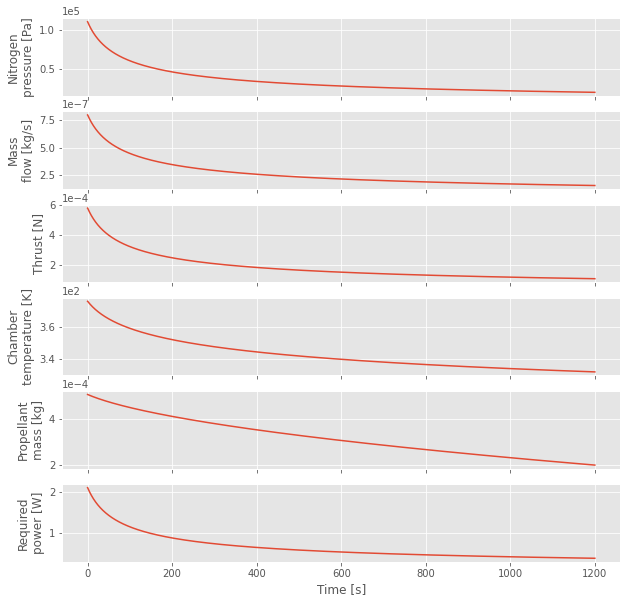

In [0]:
plt.style.use('ggplot')

fig, ax = plt.subplots(6, 1, figsize=(10,10), sharex=True)

ax[0].plot(t, p)
ax[0].set_ylabel('Nitrogen\npressure [Pa]')
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Nitrogen pressure \t[{min(p):.2e}, {max(p):.2e}] Pa')

ax[1].plot(t, mdot)
ax[1].set_ylabel('Mass\nflow [kg/s]')
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Mass flow \t\t[{min(mdot):.2e}, {max(mdot):.2e}] kg/s')

ax[2].plot(t, F_T)
ax[2].set_ylabel('Thrust [N]')
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Thrust \t\t\t[{min(F_T):.2e}, {max(F_T):.2e}] N')

ax[3].plot(t, T_c)
ax[3].set_ylabel('Chamber\ntemperature [K]')
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Chamber temperature \t[{min(T_c):.2e}, {max(T_c):.2e}] K')

ax[4].plot(t, m)
ax[4].set_ylabel('Propellant\nmass [kg]')
ax[4].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
print(f'Propellant mass \t[{min(m):.2e}, {max(m):.2e}] kg')

ax[5].plot(t, Q)
ax[5].set_ylabel('Required\npower [W]')
ax[5].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[5].set_xlabel('Time [s]')
print(f'Required power \t\t[{min(Q):.2e}, {max(Q):.2e}] W')
print(f'Input power \t\t[{min(Q/eff_Q):.2e}, {max(Q/eff_Q):.2e}] W')

## Validation

| Requirement identifier | Description                                                                                                                                        | Achieved |
|------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|----------|
| PROP-PERF-200          | The thrust provided by the propulsion system shall be 3 mN as a maximum.                                                                           | X        |
| PROP-PERF-210          | The thrust provided by the propulsion system shall be at least 0.12 mN.                                                                            |          |
| PROP-FUN-100           | The micro-propulsion system shall have at least two modes: idle with max. power consumption 15 mW, and full thrust with max. power consumption 4W. | X        |
| PROP-FUN-200           | The thruster shall be able to operate on gaseous N$_2$, as well as on liquid H$_2$O.                                                                     |          |
| PROP-RAMS-200          | The internal pressure of all propulsion system components shall not be higher than 10 bar.                                                         | X        |

---

As mentioned in [Turmaine], several choices for the operational envelope were made on a rough estimation of the VLM's thrust. **PROP-PERF-200** and even moreso **PROP-PERF-210** are difficult to validate using the given input variables. In all likelihood however, the minimum thrust of 0.12 mN will not be maintained by the VLM throughout operation, as it barely reaches this level using performance calculations that adhere to all the assumptions of Ideal Rocket Theory (IRT). Losses due to viscous effects, for example, have not been priced in yet. 

With regard to **PROP-FUN-200**: it is decided that the case using liquid water is used as a guiding setup for the system. Once the updated analytical model stands, it will be tested by replacing the relevant variables. 

# Current operational envelope - LPM


[[Guerrieri, 2018]](https://pure.tudelft.nl/portal/files/46308497/dissertation.pdf)



# Theory

## Ideal Rocket Theory - VLM

* [Experimental and Numerical Determination of Micropropulsion
Device Efficiencies at Low Reynolds Numbers](https://engineering.purdue.edu/~alexeenk/papers/aiaaj-05.pdf)
* [Experimental Study of Low
Reynolds Number Nozzles ](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19870010950.pdf)

The above operational envelope calculations do not take into account impact of the boundary layer separation caused by low Reynolds numbers which often occur in microthrusters. 

Before diving into the formulas that approach these losses, it is useful to set up the required set of formulas that describe the engine with IRT. 

From [[Makhan, 2019]](https://repository.tudelft.nl/islandora/object/uuid%3Aaaed2594-d414-4c83-967b-0cd94cccd23f):

"The nozzle discharge factor relates the experimental mass flow to the theoretical mass flow. It accounts for boundary layer effects and real gas effects (e.g. compressibility). The nozzle quality relates the experimental thrust coefficient to the theoretical thust coefficient. It accounts for losses due to friction effects, divergence and shifting gas composition. [[Suton & Biblarz]](http://mae-nas.eng.usu.edu/MAE_5540_Web/propulsion_systems/subpages/Rocket_Propulsion_Elements.pdf) [[Huzel and Huang]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19710019929.pdf) [[Spisz et al]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19650027295.pdf)."

$$ C_d = \frac{(A_t)_{eff}}{(A_t)_{ideal}} \approx \frac{\dot{m}_{exp}}{\dot{m}_{ideal}} $$

$$ \xi_F = \frac{(C_F)_{eff}}{(C_F)_{ideal}} = \frac{F(p_c\cdot A_t)^{-1}}{(C_F)_{ideal}}$$

$$ (C_F)_{ideal} = {C_F}^{\circ}  + \left( \frac{p_e}{p_c} - \frac{p_a}{p_c} \right) \cdot AR = \Gamma \cdot \sqrt{ \frac{2\gamma}{\gamma-1} \cdot \left( 1 - \left( \frac{p_e}{p_c}\right)^{\frac{\gamma-1}{\gamma}} \right)} + \left( \frac{p_e}{p_a} - \frac{p_a}{p_c} \right) \cdot \frac{A_e}{A_t}$$

$$ F = \dot{m}\cdot C_F \cdot c^* $$

$$ {C_F}^{\circ} = \frac{V_e}{c^{*}} $$

$$ \xi_s = \frac{(I_{sp})_{exp}}{(I_{sp})_{ideal}} $$

$$ \xi_b = \frac{(c^*)_{exp}}{(c^*)_{ideal}} = \frac{\xi_s}{\xi_F} $$

$$ Re = \frac{\dot{m}\cdot D_H}{\mu_t \cdot A_t} $$

$$ D_H = \frac{4A_t}{P_w} $$

$$ \frac{T_t}{T_{tot}} = \frac{\gamma + 1}{2} $$

## Losses

### Divergence loss

[[Farokhi]](https://www.wiley.com/en-us/Aircraft+Propulsion%2C+2nd+Edition-p-9781118806777)

$$ (C_F)_{div\_loss} = CA \cdot {C_F}^{\circ} + \left( \frac{p_e}{p_a} - \frac{p_a}{p_c} \right)\cdot AR$$

$$ CA_{2D-C} = \frac{\sin(\theta_{nd})}{\theta_{nd}}$$

$$ CA_{3D-C} = \frac{1+\cos(\theta_{nd})}{2}$$ 

* $C_A$: divergence loss factor [-]
* $\theta_{nd}$: nozzle divergence half angle [rad]
* 2D-C: 2D conical nozzle
* 3D-C: 3D conical nozzle


In [0]:
def C_F_divloss(CA, C_F0, p_e, p_a, p_c, AR):
    return CA*C_F0 + (p_e/p_a - p_a/p_c)*AR

def CA_2D(theta_nd):
    return np.sin(theta_nd)/theta_nd

def CA_3D(theta_nd):
    return (1+np.cos(theta_nd))/2

theta_nd = np.radians([10, 15, 20])
1-CA_3D(theta_nd)

array([0.00759612, 0.01703709, 0.03015369])

Verified using p.80 from [Zandbergen]

### Viscous loss

[[Spisz et al]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19650027295.pdf)

$$ (C_F)_{visc\_loss} = (C_F)_{ideal} - (C_F)_{visc} = (C_F)_{ideal} - \frac{17.6\cdot e^{0.0032\cdot AR}}{\sqrt{0.773Re}}$$

In [0]:
def C_F_visc(AR, Re):
    return (17.6 * np.exp(0.0032*AR))/np.sqrt(0.773*Re)

C_F0 = 1
AR = 10
Re = np.logspace(3, 7, 5)

C_F_visc(AR, Re)

array([0.65361249, 0.20669042, 0.06536125, 0.02066904, 0.00653612])

Verified using p. 86 from [Zandbergen]

### Throat boundary layer loss

[[Tang and Fenn]](https://arc.aiaa.org/doi/abs/10.2514/3.60854)

$$ R_{mod} = Re\sqrt{\frac{R^*}{R_t}} $$

$$ (C_d)_{bd\_loss} = 1-\left(\frac{\gamma+1}{2}\right)^{3 / 4}\left\{\frac{72-32 \sqrt{6}}{3(\gamma+1)}+\frac{4 \sqrt{6}}{3}\right\}\left(\frac{1}{\sqrt{R_{m o d}}}\right)+\left(\frac{2 \sqrt{2}(\gamma-1)(\gamma+2)}{3 \sqrt{\gamma+1}}\right)\left(\frac{1}{R_{m o d}}\right) $$


* $R_{mod}$: modified Reynolds number needed to calculate $ (C_d)_{bd\_loss} $
* $R^*$: radius of curvature of nozzle throat section [m]
* $R_t$: radius of nozzle throat [m] 

In [0]:
def R_mod(Re, R_curv, R_t):
    return Re*np.sqrt(R_curv/R_t)

def C_d_bdloss(g, Re, R_curv, R_t):

    A = ((g+1)/2)**(3/4) * ( (72-32*np.sqrt(6))/(3*(g+1)) + (4*np.sqrt(6))/3 )\
            * (1/np.sqrt(R_mod(Re, R_curv, R_t)))
    B = ((2*np.sqrt(2)*(g-1)*(g+2))/(3*np.sqrt(g+1)))*(1/R_mod(Re, R_curv, R_t))

    return 1 - A + B

Re = np.logspace(1, 6, 6)
gamma = 1.2
R_curv = 1
R_t = 1

C_d_bdloss(gamma, Re, R_curv, R_t)

array([0.25988292, 0.75715805, 0.922327  , 0.97534968, 0.99219609,
       0.99753131])

Verified using p.87 from [Zandbergen] (small differences attributed to rounding errors)

## Quality factors

[Zandbergen]

$$ F_{id} = m_{id}\cdot C_{F,id}\cdot c^*_{id} $$
$$ F_{real} = m_{real}\cdot C_{F,real}\cdot c^*_{real} $$

_id_: ideal

Define quality factors denoted with $\xi$:

$$ F_{real} = \xi_{F}F_{id} = C_d m_{id} \cdot \xi_n C_{F,id} \cdot \xi_c c^*_{id} = C_d m_{id} \cdot \xi_s I_{sp,id}$$

* Motor or thrust quality factor:

$$ \xi_F = \frac{F_{real}}{F_{id}} = C_d\xi_n\xi_c $$

* Discharge coefficient:

$$ \frac{m_{real}}{m_{id}} = \frac{C_d}{\xi_c} $$

* Nozzle flow quality:

$$ \xi_n = \frac{C_{F,real}}{C_{F,id}} $$

* Combustion or heating quality:

$$ \xi_c = \frac{c^*_{real}}{c^*_{id}} $$

* $I_{sp}$ or propellant consumption quality:

$$ \xi_s = \frac{I_{sp,real}}{I_{sp,id}} = \xi_n \xi_c $$

### Low throat Reynolds number 

[Zandbergen] p.60-62

Discharge coefficient [Sheshagiri]

$$ C_d = C_{\rho}C_v C_A $$

* Mass flux coefficient

$$ C_{\rho v} = \frac{(\rho v)_{eff}}{(\rho v)_{id}} $$

* Area contraction coefficient 

$$ C_A = \frac{A_{t,eff}}{A_t} $$

# Experiments

### Experimental data

| Data source     | $F$ [mN]  | $$(C_F)_{ideal}$$ [-] | $(C_F)_{exp}$ [-] | $\xi_F$ [-] | $\xi_s$ [-] | $C_d$ [-] | $Re$ [-] |
|-----------------|-----------|---------------------|-------------------|-------------|-------------|-----------|----------|
| Van Wees (2017) | 0.1-0.265 | 1.61                | 0.22-0.33         | 0.2-0.3     | 0.2-0.3     | 0.66-0.68 | 688-1200 |
| Jansen (2016)   | 15.7      | 1.348               | 1.164             | 0.89        | -           | 0.87      | 9968     |

# Updated current operational envelope - VLM

In [0]:
# Temporal components
dt = 0.1        #s
t_end = 1200    #s
t = np.arange(0, t_end, dt, dtype='f')

# Propellant properties
h = 2256e3      #J/kg
c_l = 4187      #J/K/kg liquid water
c_v = 1996      #J/K/kg water vapour
Gamma = 0.6712
R = 461.67      #J/K/kg
rho = 997       #kg/m^3
p_vap0 = 1e5
T_vap0 = 373
h_vap = 40e3
R_vap = 8.341

# Geometric & environmental properties
A_t = 4.5e-9    #m^2 
l = 0.30        #m
d = 1.57e-3     #m
T_0 = 283       #K
V_tube = (l*np.pi*(d**2))/4

# Corrections
C_d_list = np.array([0.5, 0.87])
xi_s_list = np.array([0.2, 0.3])

# Input parameters
p_0 = 1.1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
V_0 = 0.12*V_tube
eff_Q = 0.6

In [36]:
dim = (len(C_d_list), len(t))

mdot = np.zeros(dim)
p = np.zeros(dim)
T_c = np.zeros(dim)
m = np.zeros(dim)
Q = np.zeros(dim)
V_t = np.zeros(dim)
F_T = np.zeros(dim)

for i, (C_d, xi_s) in enumerate(zip(C_d_list, xi_s_list)):
    mdot[i, 0] = p_0*A_t*Gamma/(np.sqrt(R*T_c0))*C_d
    p[i, 0] = p_0
    T_c[i, 0] = T_c0
    temp = 0

    for ii, _ in enumerate(t[1:], 1):
        p[i, ii] = V_0*p_0/(V_0+temp)
        mdot[i, ii] = ((p[i, ii-1]*A_t*Gamma) / np.sqrt(R*T_c[i, ii-1]))*C_d
        T_c[i, ii] = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p[i, ii-1])+h_vap)
        temp = temp+mdot[i, ii-1]*dt/rho

    T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)
    Q[i, :] = mdot[i, :] * (T_c[i,:]-T_0)*c_l + h*mdot[i, :]
    V_t[i, :] = V_0 * (p_0 / p[i, :])
    m[i, :] = (V_tube - V_t[i, :]) * rho

    I_sp = 74*xi_s
    g_0 = 9.81
    F_T[i, :] = mdot[i, :]*I_sp*g_0

0
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

divide by zero encountered in true_divide



Text(0.5, 0, 'Time [s]')

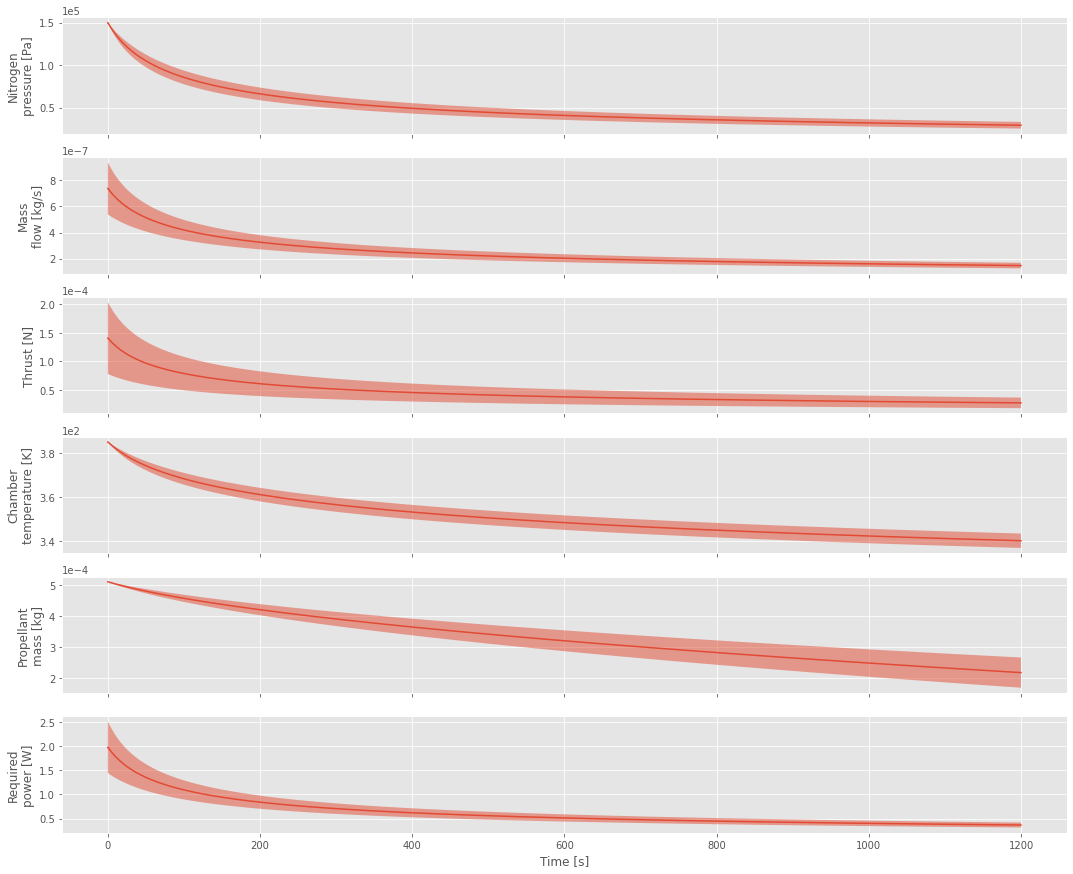

In [38]:
plt.style.use('ggplot')

fig, ax = plt.subplots(6, 1, figsize=(18,15), sharex=True)

ax[0].fill_between(t, p[0, :], p[1, :], alpha=0.5)
ax[0].plot(t, np.mean(p, axis=0))
ax[0].set_ylabel('Nitrogen\npressure [Pa]')
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Nitrogen pressure \t[{min(p):.2e}, {max(p):.2e}] Pa')

ax[1].fill_between(t, mdot[0, :], mdot[1, :], alpha=0.5)
ax[1].plot(t, np.mean(mdot, axis=0))
ax[1].set_ylabel('Mass\nflow [kg/s]')
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Mass flow \t\t[{min(mdot):.2e}, {max(mdot):.2e}] kg/s')

ax[2].fill_between(t, F_T[0, :], F_T[1, :], alpha=0.5)
ax[2].plot(t, np.mean(F_T, axis=0))
ax[2].set_ylabel('Thrust [N]')
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Thrust \t\t\t[{min(F_T):.2e}, {max(F_T):.2e}] N')

ax[3].fill_between(t, T_c[0, :], T_c[1, :], alpha=0.5)
ax[3].plot(t, np.mean(T_c, axis=0))
ax[3].set_ylabel('Chamber\ntemperature [K]')
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Chamber temperature \t[{min(T_c):.2e}, {max(T_c):.2e}] K')

ax[4].fill_between(t, m[0, :], m[1, :], alpha=0.5)
ax[4].plot(t, np.mean(m, axis=0))
ax[4].set_ylabel('Propellant\nmass [kg]')
ax[4].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# print(f'Propellant mass \t[{min(m):.2e}, {max(m):.2e}] kg')

ax[5].fill_between(t, Q[0, :], Q[1, :], alpha=0.5)
ax[5].plot(t, np.mean(Q, axis=0))
ax[5].set_ylabel('Required\npower [W]')
ax[5].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[5].set_xlabel('Time [s]')
# print(f'Required power \t\t[{min(Q):.2e}, {max(Q):.2e}] W')
# print(f'Input power \t\t[{min(Q/eff_Q):.2e}, {max(Q/eff_Q):.2e}] W')